In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [2]:
import torch
import pandas as pd
import numpy as np
import re
from modules.functions import data_generator_vec
from modules.pytorch_models import MLP_torch
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import torch.optim as optim
import torch.nn as nn
import tqdm
from torch.utils.data import DataLoader
from modules.metrics import rmse_loss, mse_loss
from modules.trained_models import get_uts_without_grain
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import glob
import pickle

In [3]:
misc_files = 'misc'
el_order_loc = os.path.join(misc_files,'element_order_uts.pkl')
with open(el_order_loc,'rb') as fid:
    el_order = pickle.load(fid)

In [4]:
uts_df = pd.read_csv('dataset/ultimate tensile strength.csv',index_col = 0)
uts_df.drop(['grain_size_micro'], axis=1,inplace=True)
uts_df.dropna(inplace=True)
uts_df.reset_index(inplace=True, drop=True)
annealed = []
for p in uts_df['process'].values:
    m = re.match(r"[^[]*\[([^]]*)\]", p).groups()[0]
    list_m = m.replace('\'','').split(',')
    list_m = [x.strip() for x in list_m]
    if 'A' in list_m:
        annealed.append(1)
    else:
        annealed.append(0)
phase_group = []
SS = ['BCC','FCC','HCP','B2']
for p in uts_df['Phase'].values:
    m = re.match(r"[^[]*\[([^]]*)\]", p).groups()[0]
    list_m = m.replace('\'','').split(',')
    list_m = [x.strip() for x in list_m]
    if len(list_m) == 1 and len(set(SS).intersection(set(list_m))) == 1:
        phase_group.append('SSP')  
    elif len(list_m) > 1 and len(set(SS).union(set(list_m))) == len(SS):
        phase_group.append('SSM')
    else:
        phase_group.append('IM')
labels = pd.get_dummies(phase_group).columns
phase_one_hot = pd.get_dummies(phase_group).values
temp = uts_df['Temperature'].values.reshape(-1,1)
annealed = np.array(annealed).reshape(-1,1)

In [13]:
np.random.seed(0)
dgen = data_generator_vec(uts_df['Composition'], el_order)
comp_feats, _ = dgen.real_data, dgen.elements
features = np.concatenate([comp_feats,temp,annealed,phase_one_hot],axis=1).astype('float32')
unscaled_y = uts_df['ultimate tensile strength'].values.astype('float32')
unscaled_y = np.array([x/1e9 for x in unscaled_y])

x_scaler = StandardScaler()
y_scaler = StandardScaler()
X = x_scaler.fit_transform(features)
y = y_scaler.fit_transform(unscaled_y.reshape(-1,1))
X,y = X.astype('float32'), y.astype('float32')
kf = KFold(n_splits=10, shuffle=True, random_state = 0)
kf.get_n_splits(X)

misc_files = 'misc'
if not os.path.exists(misc_files):
    os.makedirs(misc_files)
var_scalers = ['x','y']
for var in var_scalers:
    to_save_path = os.path.join(misc_files,'scaler_{}.pkl'.format(var))
    with open(to_save_path,'wb') as fid:
        if var == 'x':
            pickle.dump(x_scaler,fid)
        else:
            pickle.dump(y_scaler,fid)
el_order_loc = os.path.join(misc_files,'element_order_uts.pkl')
with open(el_order_loc,'wb') as fid:
    pickle.dump(el_order,fid)

## Training

In [ ]:
num_iterations = int(1e1)
log_interval = int(10)

e_it = 100
batch_size = 32

def train_mlp(train_loader, model, optimizer):
    train_loss = 0
    for data in train_loader:
        X, y = data

        
        # Train E on G's response
        optimizer.zero_grad()

        target = model(X)
        error = nn.MSELoss()(target,y)
        error.backward(retain_graph=True)
        optimizer.step()
        train_loss += error.cpu().item()
    return train_loss/len(train_loader)

for iter,(train_index, test_index) in enumerate(kf.split(X)):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        mlp = MLP_torch(X_test.shape[1],50,1)
        mlp_optimizer = optim.Adam(mlp.parameters(),lr = 1e-4)

        stat_dict = {}
        stat_dict['rmse'], stat_dict['r'] = [],[]

        for it in tqdm.notebook.tqdm(range(num_iterations)):
            Xy = [(X_train[i],y_train[i]) for i in range(X_train.shape[0])]
            train_loader = DataLoader(Xy, batch_size=batch_size, shuffle=True)

            for sub in range(e_it):
                train_loss = train_mlp(train_loader,mlp,mlp_optimizer)
                #sub_it = it * e_it + sub
                #if sub_it == 0 or (sub_it + 1) % log_interval == 0:
                #    print('Fold {} :: Iteration {} :: Sub-iteration {} :: Loss {}'.format(iter,it,sub,train_loss))
            y_pred = mlp(torch.from_numpy(X_test)).to('cpu').detach().numpy()
            y_pred_scaled = y_scaler.inverse_transform(y_pred)
            y_test_scaled = y_scaler.inverse_transform(y_test)
            stat_dict['rmse'].append(rmse_loss(y_test_scaled,y_pred_scaled))
            corr, _ = pearsonr(y_test_scaled.ravel(),y_pred_scaled.ravel())
            stat_dict['r'].append(corr)
        save_path = 'saved_models/UTS_models'
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        model_scripted = torch.jit.script(mlp.cpu())
        model_scripted.save(os.path.join(save_path,'Fold_{}.pt'.format(iter)))

In [36]:
import shutil
best_model_loc = 'saved_models'
if not os.path.exists(best_model_loc):
    os.makedirs(f'{best_model_loc}')
stat_df = pd.DataFrame.from_dict(stat_dict)
ind_max = np.argmax(stat_df['r'])
all_model_paths = sorted(glob.glob('{}/*'.format(save_path)))
best_model_path = all_model_paths[ind_max]
shutil.copy(best_model_path, os.path.join(best_model_loc,'uts_model.pt')) 

'saved_models/uts_model.pt'

## Validation

In [14]:
model = torch.jit.load('saved_models/uts_model.pt')
compositions = ['Nb17W32Zr18Ti32','Nb6Mo3W27Zr30Ti30V3','Nb47Mo13W7Zr17Ti3V13']
phases = ['SSM','SSM','SSP']
phase_group = ['SSP','SSM','IM']
temperature_list = np.arange(298,1200,10)
labels = pd.get_dummies(phase_group).columns
phase_ar = np.zeros((len(compositions),len(labels)))
for i,p in enumerate(phases):
    col_ind = np.argwhere(labels==p).item()
    phase_ar[i,col_ind] = 1
process = np.zeros((len(temperature_list)*len(compositions),1))
rep_phase_ar = np.tile(phase_ar,[len(temperature_list),1])
rep_compositions = compositions*len(temperature_list)
temperature = []
for t in temperature_list:
    temperature.extend([t]*len(compositions))
temperature = np.array(temperature).reshape(-1,1)

In [22]:
dgen_test = data_generator_vec(rep_compositions, el_order)
X = dgen_test.real_data
temp = temperature
annealed = process
phase_one_hot = rep_phase_ar
models = ['MLP']
results = {}
for m in models:
    X_test = np.concatenate([X,temp,annealed,phase_one_hot],axis=1)
    X_test_scaled = x_scaler.transform(X_test)
    
    y_pred = model(torch.from_numpy(X_test_scaled.astype('float32')))
    y_pred = y_scaler.inverse_transform(y_pred.to('cpu').detach().numpy().reshape(-1,1))
    results[m] = y_pred

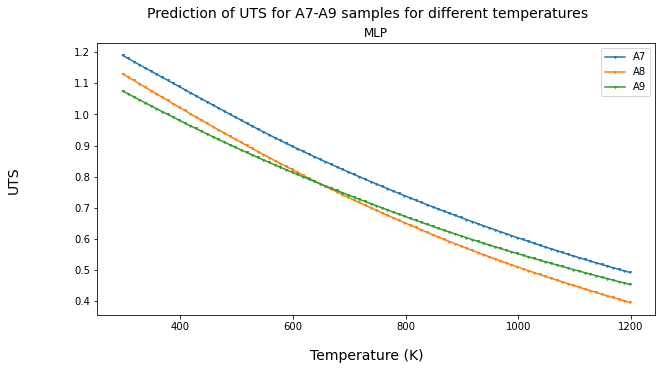

In [26]:
uniques = ['A7','A8','A9']
fig,ax = plt.subplots(figsize = (10,5))
for j,m in enumerate(results.keys()):
    for k in uniques:
        extended = np.array(uniques*len(temperature_list))
        inds = np.argwhere(extended == k)

        ax.plot(temperature[inds].flatten(),results[m][inds].flatten(), marker='v',label = k, markersize = 2)
        ax.set_title(m)
fig.text(0.5, 0.0,'Temperature (K)' , ha='center', fontsize=14)
fig.text(0.0, 0.5, 'UTS', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Prediction of UTS for A7-A9 samples for different temperatures', fontsize=14)
#plt.xlabel('Temperature (K)')
#plt.ylabel('UTS (GPa)')
plt.legend()


## Predict UTS values of synthetic compositions at 1200C

In [6]:
dataset = pd.read_csv('dataset/synthetic_dataset.csv', index_col = 0)
to_get_dset = data_generator_vec(dataset['Composition'], el_order)

In [36]:
uts_synthetic = [get_uts_without_grain(i.reshape(1,-1)).item() for i in to_get_dset.real_data]
dataset['uts1200C'] = uts_synthetic
dataset.to_csv('dataset/synthetic_dataset.csv')